# mag2exp: Microscopy techniques

This notebook is designed to go with the ______ paper and showcase the code and the techniques that `mag2exp` included in the paper.

In [1]:
%config InlineBackend.figure_formats = ['svg']

Import packages

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from tqdm import tqdm
import mag2exp
import micromagneticdata as mmd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')

Define the energy terms of the micromagnetic simulation.

In [3]:
system = mm.System(name="Microscopy_simulation")

H_max = 0.2/mm.consts.mu0
angle = 1 *np.pi/180  # Missalign the applied field by 1 degree to break symmtry.
system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T')
                 + mm.UniaxialAnisotropy(K=5.1e5, u=(0, 0, 1))
                 + mm.Demag()
                 + mm.Zeeman(H=(0, H_max*np.sin(angle), H_max*np.cos(angle))))
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='T') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Demag() + Zeeman(H=(0, 2777.6367533424855, 159130.70302317818))

Define the initial magnetisation.

In [4]:
Ms = 1.1e6  # A/m
region = df.Region(p1=(-150e-9, -150e-9, -20e-9), p2=(150e-9, 150e-9, 0))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

np.random.seed(1)  # Fix random seed to get reproducable results
def m_fun(pos):
    return 2 * np.random.rand(3) - 1

system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
system.m.sel('z').z.mpl()

Minimise the energy.

Running OOMMF (ExeOOMMFRunner)[2023/03/04 14:13]... (46.5 s)


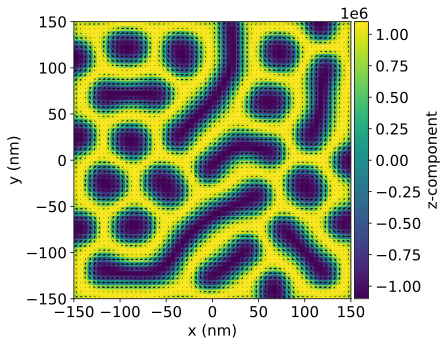

In [5]:
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
matplotlib.rcParams.update({'font.size': 15, 'figure.figsize': (7,5)})
system.m.sel('z').mpl()

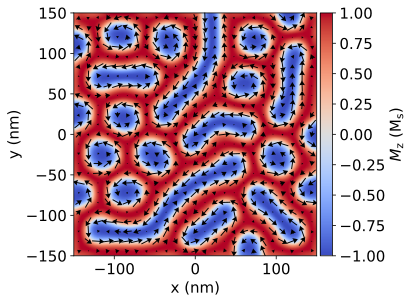

In [6]:
# PLot the paper figure.
fig, ax = plt.subplots(figsize=(6,6))
system.m.orientation.sel('z').z.mpl.scalar(ax=ax, cmap='coolwarm', clim=(-1,1), colorbar_label=r'$M_\mathrm{z}$ $(\mathrm{M}_\mathrm{s})$', interpolation='spline16',)
system.m.orientation.sel('z').resample((25,25)).mpl.vector(ax=ax, use_color=False, scale=20, headwidth=6, width=0.004)
plt.tight_layout()
#plt.savefig('magnetistion.png', bbox_inches='tight', dpi=600)

## LTEM

Calculate the defocused images producing using LTEM.

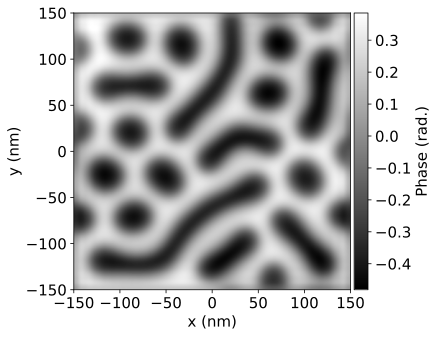

In [7]:
phase, ft_phase = mag2exp.ltem.phase(system.m)
phase.mpl.scalar(cmap='gray',
                 interpolation='spline16',
                 colorbar_label='Phase (rad.)')

In [8]:
df_image = mag2exp.ltem.defocus_image(phase,
                                      voltage=300e3,
                                      df_length=-0.2e-3)
df_image.mpl.scalar(cmap='gray',
                    interpolation='spline16',
                    colorbar_label='Intensity (counts)')

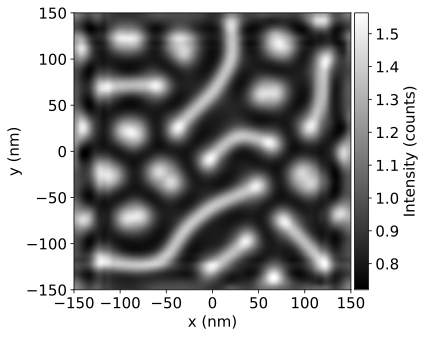

In [9]:
mag2exp.quick_plots.ltem_defocus(system.m, voltage=300e3, df_length=-0.2e-3)

## Holography image
Calculate the x-ray holography image

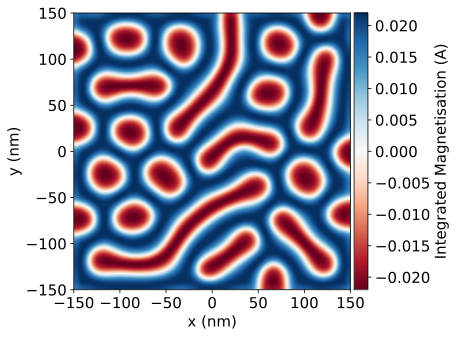

In [10]:
mag2exp.quick_plots.x_ray_holography(system.m)

Add at 20 nm Gaussian filter

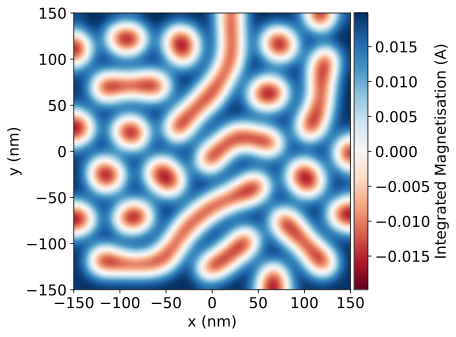

In [11]:
mag2exp.quick_plots.x_ray_holography(system.m, fwhm=(20e-9, 20e-9))

## MFM
Magnetic force microsopy technique.
Define a new magnetisation field with an "airbox" in which the MFM is calculated.

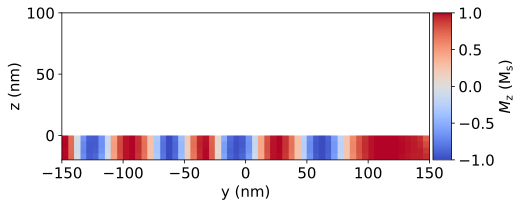

In [12]:
mfm_field = system.m.pad({'z': (0, 20)}, mode='constant')
mfm_field.sel('x').orientation.z.mpl.scalar(
    cmap='coolwarm',
    colorbar_label=r'$M_\mathrm{z}$ $(\mathrm{M}_\mathrm{s})$',
    clim=(-1,1)
)

Calcualte the phase shift of the MFM tip.

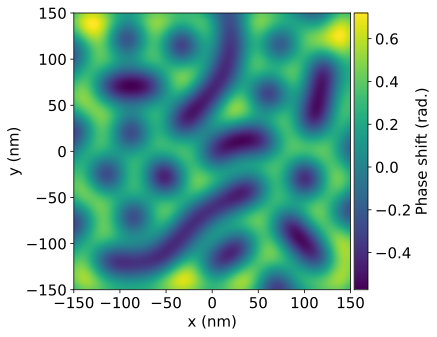

In [13]:
mfm_phase = mag2exp.mfm.phase_shift(mfm_field,
                                    tip_m=(0., 0., 1e-16),
                                    quality=650,
                                    k=3)
mfm_phase.sel(z=50e-9).mpl.scalar(interpolation='spline16',
                                    colorbar_label='Phase shift (rad.)')

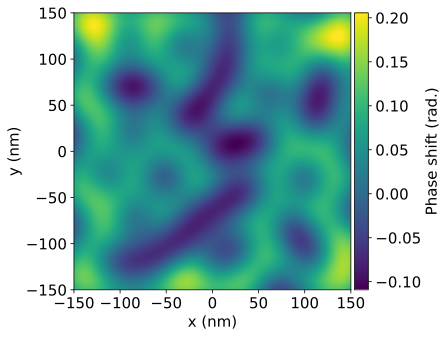

In [14]:
mfm_phase.sel(z=70e-9).mpl.scalar(interpolation='spline16',
                                    colorbar_label='Phase shift (rad.)')

In [17]:
mfm_phase.hv(kdims=['x', 'y'])

:DynamicMap   [z]
   :Image   [x,y]   (field)